# Request
Show us a visual representation that explores danceability, popularity, and song key. Potential questions that could be asked are: What song key has the most danceability? How does popularity and song key relate? Are the most popular songs also the most danceable?

# In this notebook
- Averages
- Min / Max 

# Setup
This notebook needs the following:
- matplotlib
- pandas
- sqlite3
- numpy



### Averages
 - Load data from "music_genre.csv" in folder using pandas. 
 - Save the data frame back to SQLite for convenience. 
    - Note that when we pull data out of sqlite we're normalizing popularity to make it easier to chart.
 - Plot items using pyplot from matlab.
 - (Stretch Goal) Output to tables, coloring max/min values if possible.

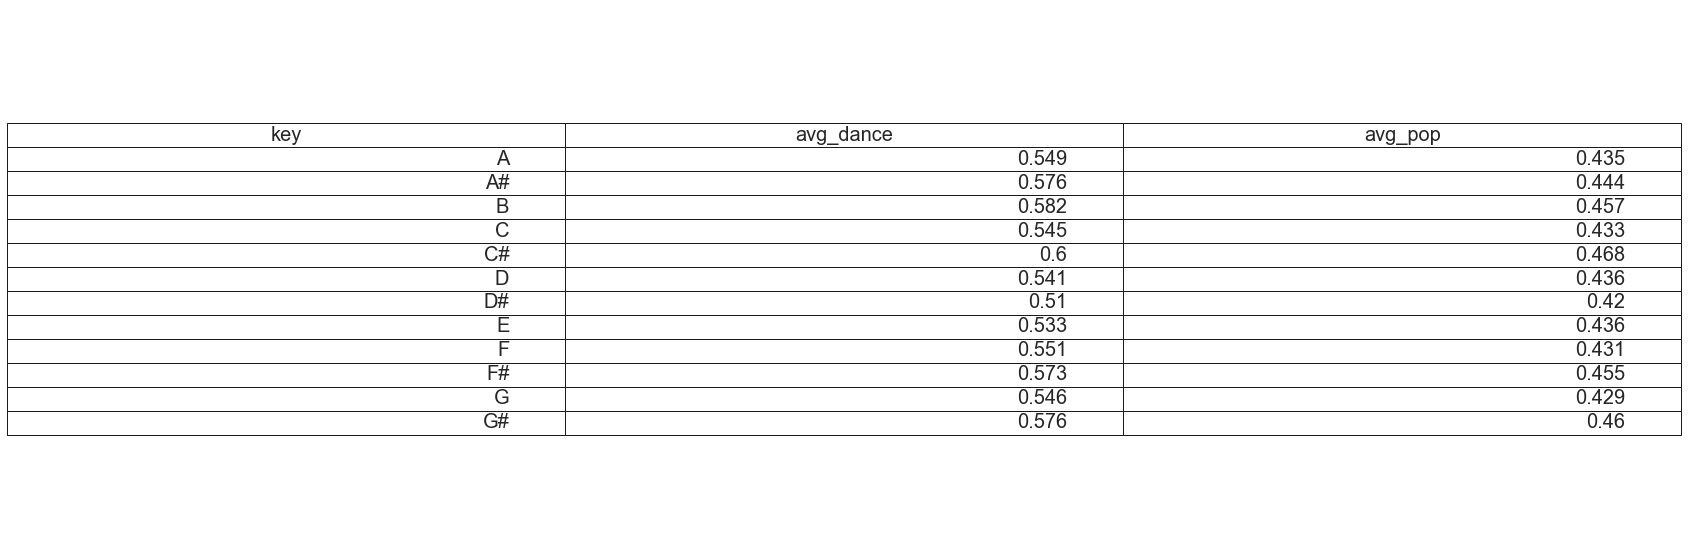

The minimum average dance value is:  0.51 by key  D#
The maximum average dance value is:  0.6 by key  C#
The minimum average pop value is:  0.42 by key  D#
The maximum average pop value is:  0.468 by key  C#


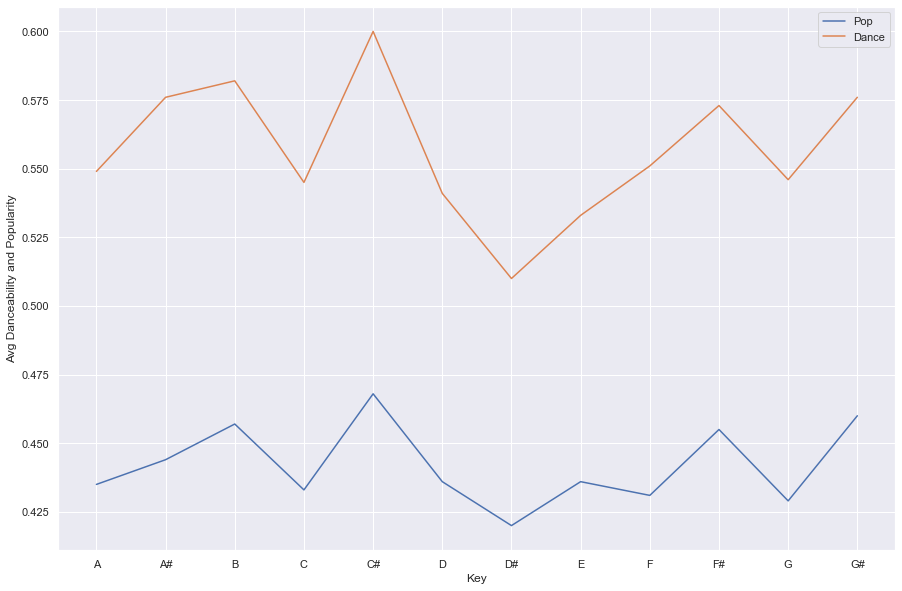

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np

# read csv
data = pd.read_csv('music_genre.csv')

# create an in-memory sqlite database and save the data frame to it
# used to using sql, although we can use sql against dataframes as well
conn = sqlite3.connect(":memory:")
data.to_sql(name='music', con=conn)

# get the average by key
# we multiply the popularity by 0.01 to try and normalize (produce a value between 0 and 1)
query = """SELECT 
                key,
                ROUND(AVG(danceability), 3) avg_dance, 
                ROUND(AVG(popularity) * 0.01, 3) avg_pop
            FROM 
                music
            WHERE
                danceability IS NOT NULL
            AND
                popularity IS NOT NULL                 
            GROUP BY 
                key"""

data_avg = pd.read_sql(query, conn)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=data_avg.values, colLabels=data_avg.columns, loc='center')

# https://stackoverflow.com/questions/15514005/how-to-change-the-tables-fontsize-with-matplotlib-pyplot
table.set_fontsize(20)
table.scale(2, 2)
plt.show()   

# output some quick observations
print('The minimum average dance value is: ', str(data_avg['avg_dance'].min()) , 'by key ' , data_avg.loc[data_avg['avg_dance'] == data_avg['avg_dance'].min()]['key'].to_string(index=False))
print('The maximum average dance value is: ', str(data_avg['avg_dance'].max()) , 'by key ' , data_avg.loc[data_avg['avg_dance'] == data_avg['avg_dance'].max()]['key'].to_string(index=False))

print('The minimum average pop value is: ', str(data_avg['avg_pop'].min()) , 'by key ' , data_avg.loc[data_avg['avg_pop'] == data_avg['avg_pop'].min()]['key'].to_string(index=False))
print('The maximum average pop value is: ', str(data_avg['avg_pop'].max()) , 'by key ' , data_avg.loc[data_avg['avg_pop'] == data_avg['avg_pop'].max()]['key'].to_string(index=False))

# https://datascienceparichay.com/article/plot-a-line-chart-in-python-with-matplotlib/
# not sure if a line graph is the best visual here, because we're not doing changes over time
plt.plot(data_avg['key'].tolist(), data_avg['avg_pop'].tolist())
plt.plot(data_avg['key'].tolist(), data_avg['avg_dance'].tolist())
plt.xlabel("Key")
plt.ylabel("Avg Danceability and Popularity")
plt.legend(["Pop","Dance"])
plt.show()

#### Quick Sanity Check
Use data frame to also view averages

In [65]:
# sanity checks against SQL 
print('danceability averages by key')
print(data.groupby('key')['danceability'].mean())
print('popularity averages by key')
print(data.groupby('key')['popularity'].mean())

danceability averages by key
key
A     0.548966
A#    0.576041
B     0.581897
C     0.545203
C#    0.600170
D     0.541076
D#    0.509633
E     0.533237
F     0.551330
F#    0.573403
G     0.545565
G#    0.575717
Name: danceability, dtype: float64
popularity averages by key
key
A     43.509223
A#    44.412992
B     45.662180
C     43.301702
C#    46.806660
D     43.599430
D#    41.955975
E     43.592819
F     43.082009
F#    45.534021
G     42.926838
G#    46.005122
Name: popularity, dtype: float64


### Min / Max

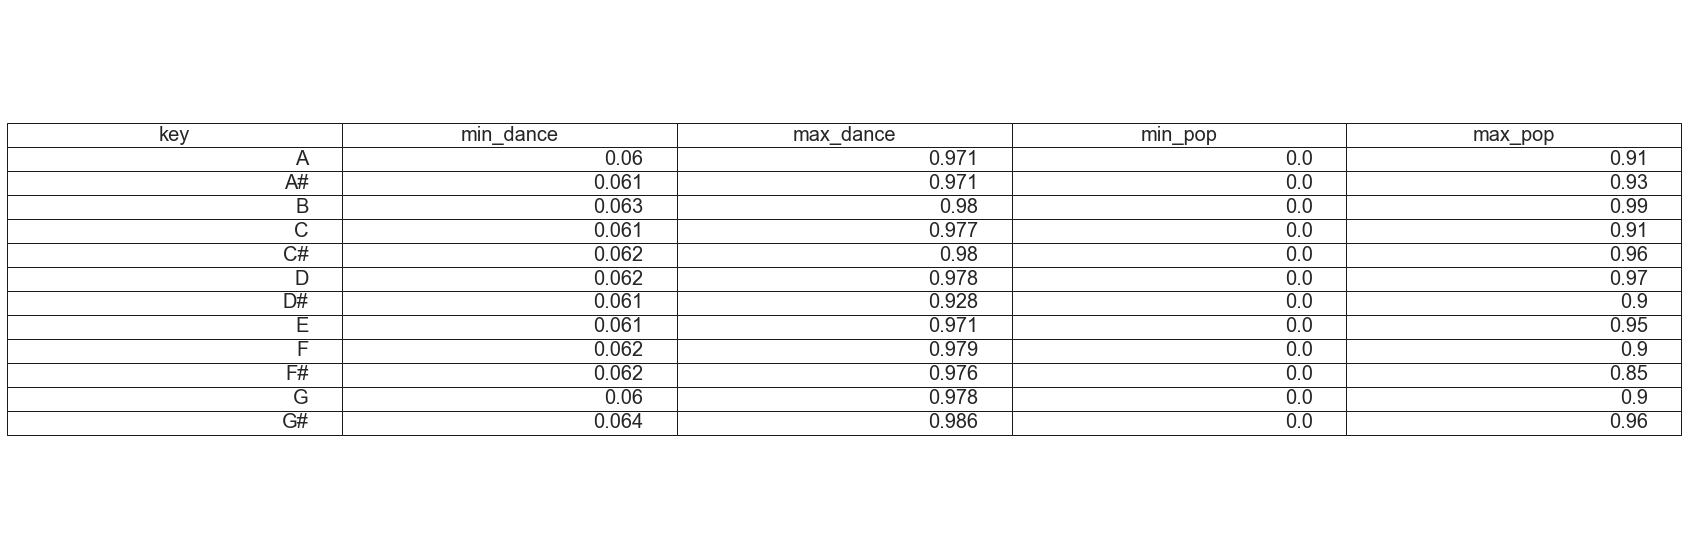

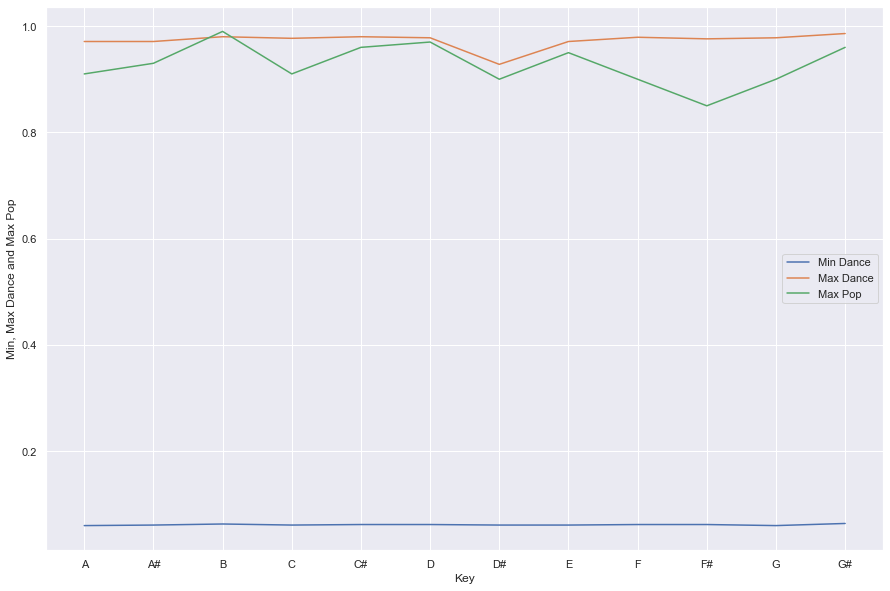

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# grab danceability, popularity, and key from the table we just created
query = """
        SELECT 
            key,
            ROUND(MIN(danceability), 3) min_dance, 
            ROUND(MAX(danceability), 3) max_dance, 
            ROUND(MIN(popularity), 3) min_pop, 
            ROUND(MAX(popularity) * 0.01, 3) max_pop
        FROM 
            music
        WHERE
            danceability IS NOT NULL
        AND
            popularity IS NOT NULL                     
        GROUP BY 
            key"""

# print(pd.read_sql_query(query, conn))
df = pd.read_sql(query, conn)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.set_fontsize(20)
table.scale(2, 2)
plt.show()

plt.plot(df['key'].tolist(), df['min_dance'].tolist())
plt.plot(df['key'].tolist(), df['max_dance'].tolist())
plt.plot(df['key'].tolist(), df['max_pop'].tolist())
plt.xlabel("Key")
plt.ylabel("Min, Max Dance and Max Pop")
plt.legend(["Min Dance","Max Dance", "Max Pop"])
plt.show()


### Other Plots


##### Popularity

<AxesSubplot:xlabel='key', ylabel='popularity'>

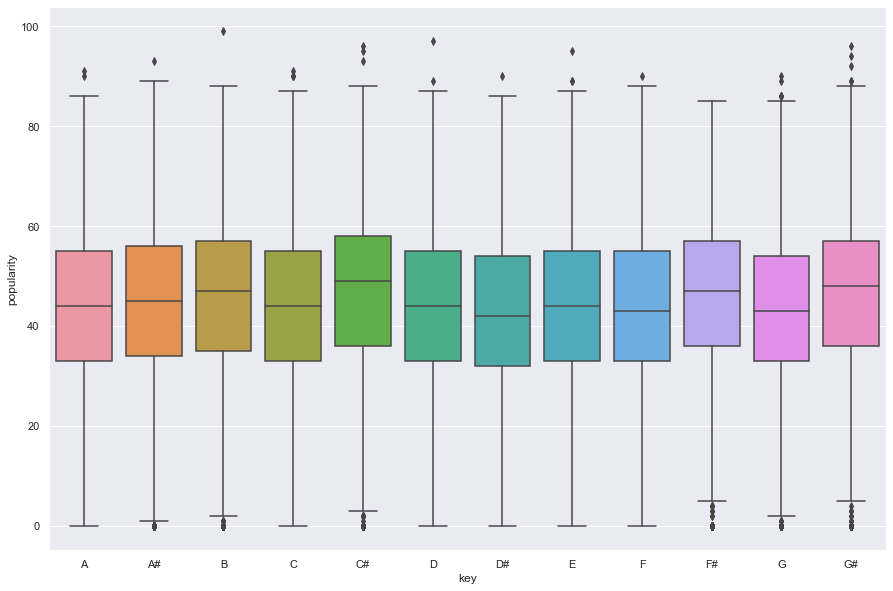

In [67]:
import seaborn as sns
sns.set(rc={"figure.figsize":(15, 10)}) #width, #height
sns.boxplot(x=plot_data['key'], y = plot_data['popularity'], data=plot_data)

<AxesSubplot:xlabel='key', ylabel='popularity'>

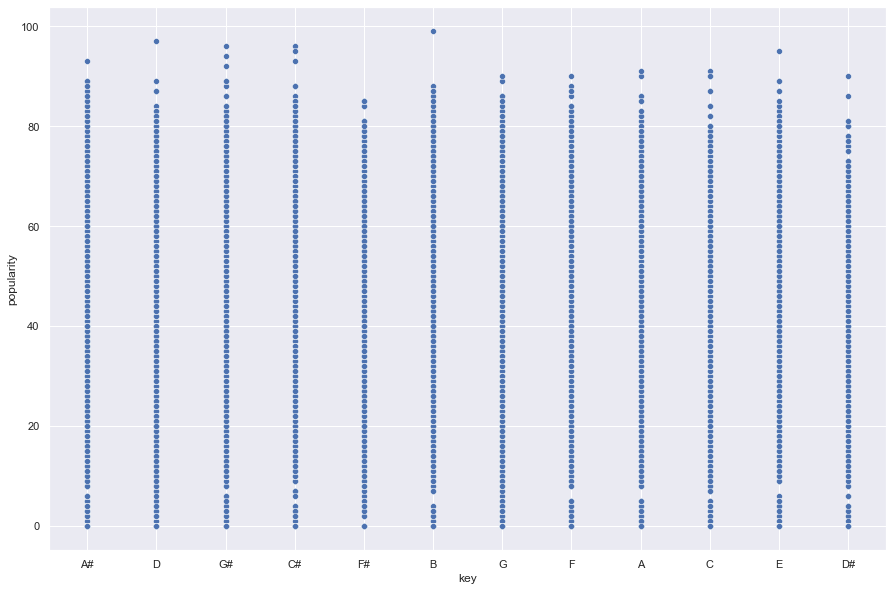

In [68]:
sns.scatterplot(x=data['key'], y = data['popularity'], data=data)

##### Danceability

<AxesSubplot:xlabel='key', ylabel='danceability'>

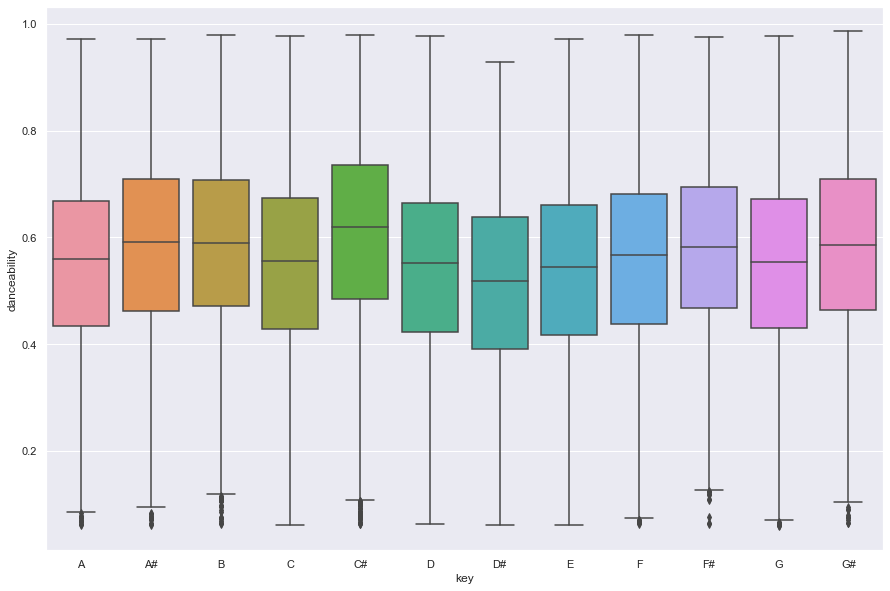

In [69]:
import seaborn as sns
sns.set(rc={"figure.figsize":(15, 10)}) #width, #height
sns.boxplot(x=plot_data['key'], y = plot_data['danceability'], data=plot_data)

<AxesSubplot:xlabel='key', ylabel='danceability'>

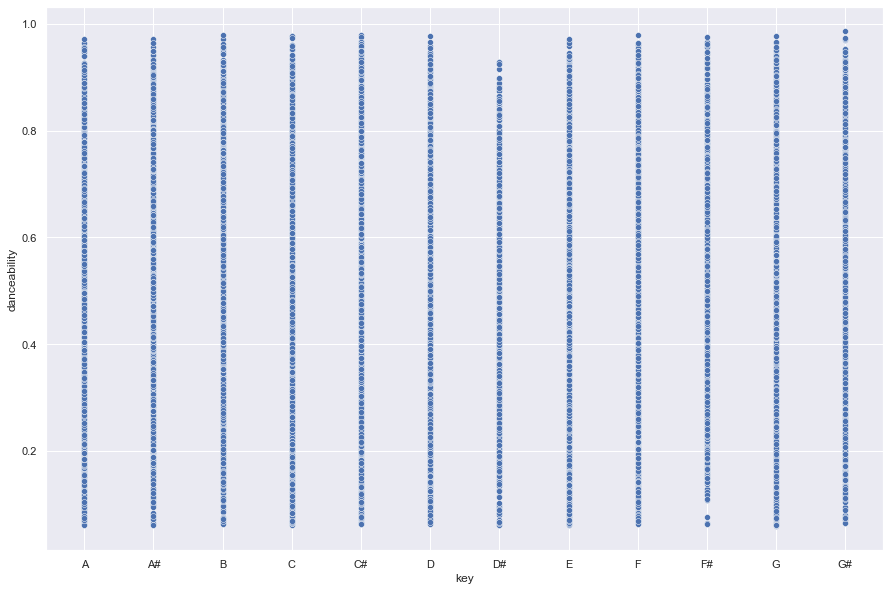

In [70]:
sns.scatterplot(x=plot_data['key'], y = plot_data['danceability'], data=plot_data)